# Yogurt Sales

This notebook contains multiple elements of my analysis:
* Data Exploration of Drug Store and Grocery Store Sales Data
* Data Exploration of Sale Promotions
* Data Exploration of the Products table
* Modeling of Sales Promotions (including feature engineering/selection, tuning, validation)
* Attempt to improve Sales Promtion Model by incorporating my team memeber's findings
* Modeling of Unit Sales 

# Feature Engineering/Selection -- Sales & Products

In this section I am looking at how the attributes in the Sales table and Product tables affect the sales of yogurt. There will be four data sets from the IRI used here; 
* Grocery -- store data files for outlet=G and category= yogurt
* Drug -- store data files for outlet=D and category=yogurt
* Product -- product attribute files for yogurt
* IRI Week converter -- files containing the conversion from IRI Week to calendar week

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar as cal
import datetime as dt
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
%matplotlib inline

## Sales (drug and grocery)

Original Data:
* IRI_KEY -- Masked store number (key to delivery_stores)
* WEEK -- IRI week (needs translation for calendar week)
* SY -- UPC System
* GE -- UPC Generation
* VEND -- UPC Vendor
* ITEM -- Item
* UNITS -- total units sales
* DOLLARS -- total dollar sales
* F -- Promotion flag
* D -- Display flag
* PR -- price reduction flag

Analysts Added:
* file -- the original file that held the data.  The nameing convention is category, outlet, start week then end week. 
* year_int -- the year folder 
* upc -- UPC code to match products table (2 digit system, 2 digit generation, 5 digit vendor, 5 digit item)
* ExistPromo -- 1 if there exists some promotion that week, 0 o.w.
* ExistDisplay -- 1 if there exists some display for the product that week, 0 o.w.
* F_A, F_A+, F_B,F_C,F_None, etc. -- Converted F promotional flag into binary
* NoDisplay, SmallDisplay, LargeDisplay -- Converted D display flag into binary
* Calendar week starting on -- start date of IRI week
* Calendar week ending on -- end date of IRI week
* WeekOfYear -- the week number (1-52(53)) of the year
* Month -- the month number (1-12) of the year
* Year -- year
* drug -- 1 if outlet is drug store, 0 o.w
* groc -- 1 if outlet is grocery store, 0 o.w
* price -- price per unit
* More_1_std -- 1 if weekly unit sales are more than 1 std away from mean, 0 o.w.

In [2]:
Drug=pd.read_hdf('yogurt.h5','drug')
Drug['upc']=Drug.apply(lambda x:'%02d-%02d-%02d-%02d' % (x['SY'],x['GE'],x['VEND'],x['ITEM']),axis=1)
Drug['ExistPromo']= np.where(Drug['F']=='NONE', 0, 1)
Drug['ExistDisplay']=np.where(Drug['D']==0, 0, 1)
Drug['drug']=1
Drug['groc']=0
Drug['price']=Drug['DOLLARS']/Drug['UNITS']

F=pd.get_dummies(Drug['F'])
F.columns='F_'+F.columns

D=pd.get_dummies(Drug['D'])
D.columns=['NoDisplay','SmallDisplay','LargeDisplay']

Drug=pd.concat([Drug,F,D],axis=1)

WeekConvert=pd.read_csv('IRI week translation.csv')
Drug=pd.merge(Drug,WeekConvert,left_on='WEEK',right_on='IRI Week')
del Drug['WEEK']
Drug.head()

,IRI_KEY,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,...,F_NONE,NoDisplay,SmallDisplay,LargeDisplay,IRI Week,Calendar week starting on,Calendar week ending on,WeekOfYear,Month,Year
0,8042577,0,1,70470,300,2,1.78,NONE,0,0,...,1,1,0,0,1133,14-May-01,20-May-01,20,5,2001
1,8044648,0,2,78255,429,2,1.18,NONE,0,0,...,1,1,0,0,1133,14-May-01,20-May-01,20,5,2001
2,8041920,7,1,9426,43,2,1.78,NONE,0,0,...,1,1,0,0,1133,14-May-01,20-May-01,20,5,2001
3,8041920,7,1,9426,51,1,0.89,NONE,0,0,...,1,1,0,0,1133,14-May-01,20-May-01,20,5,2001
4,8041920,0,1,70470,300,4,3.56,NONE,0,0,...,1,1,0,0,1133,14-May-01,20-May-01,20,5,2001


Note:  The grocery store sales data is too large to fit in memory.  So for initial exploration and feature engineering, I will use a random sample.

In [3]:
store = pd.HDFStore('yogurt.h5')
nrows = store.get_storer('groc').nrows
r = np.random.randint(0,nrows,size=10000)
Groc=pd.read_hdf('yogurt.h5','groc',where=pd.Index(r))
Groc['upc']=Groc.apply(lambda x:'%02d-%02d-%02d-%02d' % (x['SY'],x['GE'],x['VEND'],x['ITEM']),axis=1)
Groc['ExistPromo']= np.where(Groc['F']=='NONE', 0, 1)
Groc['ExistDisplay']=np.where(Groc['D']==0, 0, 1)
Groc['drug']=0
Groc['groc']=1
Groc['price']=Groc['DOLLARS']/Groc['UNITS']

F=pd.get_dummies(Groc['F'])
F.columns='F_'+F.columns

D=pd.get_dummies(Groc['D'])
D.columns=['NoDisplay','SmallDisplay','LargeDisplay']

Groc=pd.concat([Groc,F,D],axis=1)

Groc=pd.merge(Groc,WeekConvert,left_on='WEEK',right_on='IRI Week')
del Groc['WEEK']
Groc.head()

,IRI_KEY,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,...,F_NONE,NoDisplay,SmallDisplay,LargeDisplay,IRI Week,Calendar week starting on,Calendar week ending on,WeekOfYear,Month,Year
0,286681,0,1,70470,303,38,34.20,NONE,0,0,...,1,1,0,0,1509,28-Jul-08,3-Aug-08,31,7,2008
1,652317,88,3,99998,15811,4,2.00,NONE,0,0,...,1,1,0,0,1509,28-Jul-08,3-Aug-08,31,7,2008
2,240093,0,1,70470,27106,12,9.00,NONE,0,0,...,1,1,0,0,1509,28-Jul-08,3-Aug-08,31,7,2008
3,287183,0,1,36632,3505,1,5.43,NONE,0,0,...,1,1,0,0,1509,28-Jul-08,3-Aug-08,31,7,2008
4,235225,0,2,36632,180,14,12.18,NONE,0,0,...,1,1,0,0,1509,28-Jul-08,3-Aug-08,31,7,2008


To start, lets just explore the correlations between the attributes.  No attribute have extremly large (negative or positive) correlation too sales but there are those that are higher than others.

Looking at the correltation tables below it appears that for drug stores the presence of displays have the highest correlation to sales.  For grocery stores, promortions have the highest correlation to sales.  Price also has a large negative correlation.

After combining the data from the two outlets, we see that there is a high correlation between the outlet type and sales.  Also that large displays and large ads have highest correlation to sales (among promotions and displays).  And for both types, price reductions correlate to sales.

In [4]:
col=Drug.columns
Drug[col[[5,6,9,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]].corr()[['UNITS','DOLLARS']]

,UNITS,DOLLARS
UNITS,1.000000,0.835285
DOLLARS,0.835285,1.000000
PR,0.184747,0.067103
ExistPromo,0.108720,0.058765
ExistDisplay,0.156507,0.111285
price,-0.158889,0.211342
F_A,0.093263,0.058209
F_A+,0.072925,0.017488
F_B,0.041384,0.034808
F_C,0.012556,0.013403


In [5]:
col=Groc.columns
Groc[col[[5,6,9,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]].corr()[['UNITS','DOLLARS']]

,UNITS,DOLLARS
UNITS,1.000000,0.711595
DOLLARS,0.711595,1.000000
PR,0.228792,0.072091
ExistPromo,0.304654,0.146376
ExistDisplay,0.143304,0.110976
price,-0.309739,0.139199
F_A,0.259950,0.109104
F_A+,0.053155,0.030560
F_B,0.165465,0.090893
F_C,0.009700,0.006758


In [6]:
StoreData=pd.concat([Drug,Groc],axis=0)
col=StoreData.columns
StoreData[col[[5,6,15,16]]].corr()[['UNITS','DOLLARS']]

,UNITS,DOLLARS
UNITS,1.000000,0.803465
DOLLARS,0.803465,1.000000
drug,-0.346029,-0.367893
groc,0.346029,0.367893


In [7]:
StoreData[col[[5,6,9,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]].corr()[['UNITS','DOLLARS']]

,UNITS,DOLLARS
UNITS,1.000000,0.803465
DOLLARS,0.803465,1.000000
PR,0.168810,0.075711
ExistPromo,0.162782,0.099676
ExistDisplay,0.139980,0.109561
price,-0.129799,0.207908
F_A,0.167211,0.100211
F_A+,0.048098,0.010815
F_B,0.086679,0.067036
F_C,0.027282,0.026433


In order to dive deeper into the relationships that promotions, displays and price reductions have on yogurt sales, I will restrict the data to a couple of stores with a handful of yogurt products for a given year.  Randomly choosen year 2011 to look at, also requiring that the store sell yogurt for at least 40 weeks of the year.  Will pick 2 stores randomly.

Firstly, I want to see if sales increase or decrease by a statistically significant amount in the presense of promotions, displays or price reductions.  Note: I'm considering more than one standard deviation away from the mean as "statistically significant".

In [8]:
# Counts how many weeks a particular store sells a particular type of yogurt
Counts=StoreData.groupby(['IRI_KEY','upc','Year'])['UNITS'].count()
df=pd.DataFrame(Counts)
df.reset_index(inplace=True)

#Pick subset of store/products from 2011 for further investigation
s=df[(df['UNITS']>40) & (df['Year']==2011)]['IRI_KEY'].unique()[:2] #pick stores
Subset=StoreData[((StoreData['IRI_KEY']==s[0]) & (StoreData['Year']==2011)) | ((StoreData['IRI_KEY']==s[1]) & (StoreData['Year']==2011))]

#Calculate the mean weekly units sold of each yogurt type
m=Subset.groupby(['IRI_KEY','upc'])['UNITS'].mean()
std=Subset.groupby(['IRI_KEY','upc'])['UNITS'].std()
Mean=pd.DataFrame(m)
Mean.reset_index(inplace=True)
Mean.columns=['IRI_KEY','upc','mean']
Std=pd.DataFrame(std)
Std.reset_index(inplace=True)
Std.columns=['IRI_KEY','upc','std']
Stat=pd.merge(Mean,Std,left_on=['IRI_KEY','upc'],right_on=['IRI_KEY','upc']).dropna()
Stat.head()

#Add the mean and std to each row of Subset.
SubsetStat=pd.merge(Subset[col[[0,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]],Stat,left_on=['IRI_KEY','upc'],right_on=['IRI_KEY','upc'],how='outer')
# Create new column, "More_1_std", which is 1 when unit sales that week more than one std away from mean
SubsetStat['More_1_std']=SubsetStat.apply(lambda x: 1 if x['UNITS']> x['mean']+x['std'] or x['UNITS']< x['mean']-x['std'] else 0 ,axis=1)
SubsetStat.head()


,IRI_KEY,UNITS,DOLLARS,PR,upc,ExistPromo,ExistDisplay,drug,groc,price,...,F_A+,F_B,F_C,F_NONE,NoDisplay,SmallDisplay,LargeDisplay,mean,std,More_1_std
0,263037,55,43.45,0,00-01-70470-650,0,0,1,0,0.79,...,0,0,0,1,1,0,0,33.156863,12.283929,1
1,263037,53,41.87,0,00-01-70470-650,0,0,1,0,0.79,...,0,0,0,1,1,0,0,33.156863,12.283929,1
2,263037,25,19.75,0,00-01-70470-650,0,0,1,0,0.79,...,0,0,0,1,1,0,0,33.156863,12.283929,0
3,263037,36,35.64,0,00-01-70470-650,0,0,1,0,0.99,...,0,0,0,1,1,0,0,33.156863,12.283929,0
4,263037,17,16.83,0,00-01-70470-650,0,0,1,0,0.99,...,0,0,0,1,1,0,0,33.156863,12.283929,1


In [9]:
promo=['PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
for p in promo:
    c=SubsetStat[p][SubsetStat[p]==1].count()
    s=SubsetStat['More_1_std'][SubsetStat[p]==1].sum()
    print "%s: Total weeks = %1.0f, Stat Sig weeks = %1.0f" % (p,c,s)
print " --> Total Stat Sig weeks = %1.0f" % SubsetStat['More_1_std'].sum()

PR: Total weeks = 163, Stat Sig weeks = 66
ExistPromo: Total weeks = 0, Stat Sig weeks = 0
ExistDisplay: Total weeks = 21, Stat Sig weeks = 4
F_A: Total weeks = 0, Stat Sig weeks = 0
F_A+: Total weeks = 0, Stat Sig weeks = 0
F_B: Total weeks = 0, Stat Sig weeks = 0
F_NONE: Total weeks = 1254, Stat Sig weeks = 372
NoDisplay: Total weeks = 1233, Stat Sig weeks = 368
SmallDisplay: Total weeks = 0, Stat Sig weeks = 0
LargeDisplay: Total weeks = 21, Stat Sig weeks = 4
 --> Total Stat Sig weeks = 372


Looks like my subset was too small.  It doesn't include all the different types of promotions and displays.  But it did serve as proof of concept.  Now, I am going to do the same thing as above but on all the data.

In [10]:
#Calculate the mean weekly units sold of each yogurt type
m=StoreData.groupby(['IRI_KEY','upc'])['UNITS'].mean()
std=StoreData.groupby(['IRI_KEY','upc'])['UNITS'].std()
Mean=pd.DataFrame(m)
Mean.reset_index(inplace=True)
Mean.columns=['IRI_KEY','upc','mean']
Std=pd.DataFrame(std)
Std.reset_index(inplace=True)
Std.columns=['IRI_KEY','upc','std']
Stat=pd.merge(Mean,Std,left_on=['IRI_KEY','upc'],right_on=['IRI_KEY','upc']).dropna()
Stat.head()

#Add the mean and std to each row of Subset.
StoreStat=pd.merge(StoreData[col[[0,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]],Stat,left_on=['IRI_KEY','upc'],right_on=['IRI_KEY','upc'],how='outer')
# Create new column, "More_1_std", which is 1 when unit sales that week more than one std away from mean
StoreStat['More_1_std']=StoreStat.apply(lambda x: 1 if x['UNITS']> x['mean']+x['std'] or x['UNITS']< x['mean']-x['std'] else 0 ,axis=1)
StoreStat.dropna()

# Get a break down:
promo=['PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
for p in promo:
    c=StoreStat[p][StoreStat[p]==1].count()
    s=StoreStat['More_1_std'][StoreStat[p]==1].sum()
    per=float(s)/float(c)
    print "%s: Total weeks = %1.0f, Stat Sig weeks = %1.0f -- %1.2f " % (p,c,s,per)
print " --> Total Stat Sig weeks = %1.0f" % StoreStat['More_1_std'].sum()


PR: Total weeks = 52397, Stat Sig weeks = 14933 -- 0.28 
ExistPromo: Total weeks = 10468, Stat Sig weeks = 4021 -- 0.38 
ExistDisplay: Total weeks = 1643, Stat Sig weeks = 697 -- 0.42 
F_A: Total weeks = 1864, Stat Sig weeks = 664 -- 0.36 
F_A+: Total weeks = 2930, Stat Sig weeks = 1477 -- 0.50 
F_B: Total weeks = 5638, Stat Sig weeks = 1877 -- 0.33 
F_NONE: Total weeks = 357220, Stat Sig weeks = 73130 -- 0.20 
NoDisplay: Total weeks = 366045, Stat Sig weeks = 76454 -- 0.21 
SmallDisplay: Total weeks = 432, Stat Sig weeks = 129 -- 0.30 
LargeDisplay: Total weeks = 1211, Stat Sig weeks = 568 -- 0.47 
 --> Total Stat Sig weeks = 77151


While not all the time, it does appear that promotions, displays and price reductions can have a statistically significant effect on sales.  These number complement the discovery that there exist a correlation but not a terribly strong one.


# Sales Promotion Model -- Predict Promotion Success

We are going to build a model to predict the outcome of promotions, displays and price reductions in yogurt sales.  It is a classification model where the inputs are the types of promotions/displays/price reduction and the label is {0,1} i.e {no change, stat sig change in sales}.  This type of model could be used to determine if a planned "promotion" will increase sales to a statistically significant degree.

Model Score:  0.791656364865
Cross Valid Scores:  [ 0.79129725  0.79039408  0.79594223  0.7936305   0.78957818  0.79115559
  0.79012211  0.79033399  0.79011641  0.78260988]


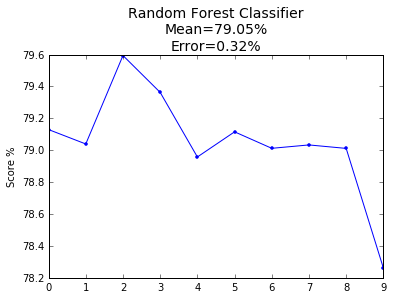

In [11]:
promo=['PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
X=StoreStat[promo].as_matrix()
y=StoreStat['More_1_std'].as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Model Score: ",RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print 'Cross Valid Scores: ', scores

plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

Let's see if I can imporve the model by adding price and grocery store/drug store

Model Score:  0.792084919811
Cross Valid Scores:  [ 0.79159641  0.79044848  0.79618701  0.79387528  0.78957818  0.79115559
  0.79012211  0.79036118  0.79011641  0.78478568]


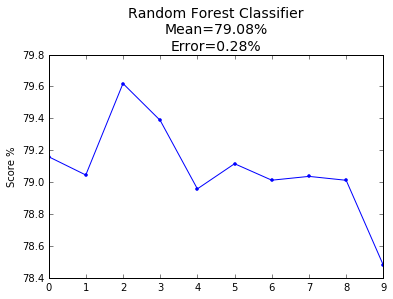

In [12]:
more1=['groc','drug','PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
X=StoreStat[more1].as_matrix()
y=StoreStat['More_1_std'].as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Model Score: ",RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print 'Cross Valid Scores: ', scores

plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

Model Score:  0.786399613163
Cross Valid Scores:  [ 0.78315884  0.78489446  0.78570029  0.78256488  0.77724588  0.78034714
  0.75705487  0.78309071  0.73645017  0.77922732]


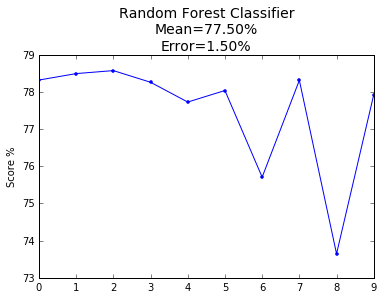

In [13]:
StoreStat['price']=StoreStat['price'].replace([np.inf,-np.inf],np.nan)
StoreStat=StoreStat.dropna()
more2=['price','PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
X=StoreStat[more2].as_matrix()
y=StoreStat['More_1_std'].as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Model Score: ",RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print 'Cross Valid Scores: ', scores

plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

Looks like neither price nor outlet (drug store or grocery) improve our model.  What about information about the store and products?  Since the label is a store/product increase in sales perhaps the model would improve knowing which store is running the promotion on which product.  That is the next model we will build

In [ ]:
# Note:  To include store and yogurt item in the model, we have to binary encode them.
# This is because sklearn decision trees can not handle categorical values naturally like some other ML programs

# StoreStat['iriKey']=StoreStat.apply(lambda x:'%s' % (x['IRI_KEY']),axis=1)
# Bin=pd.get_dummies(StoreStat[['iriKey','upc']])
# X=pd.concat([StoreStat[promo],Bin])
# X=X.as_matrix()
# y=StoreStat['More_1_std'].as_matrix()

# #Split Training/Testing data set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# RFC=RandomForestClassifier()
# RFC.fit(X_train,y_train)
# RFC.score(X_test,y_test)

## ****** PROBLEM:  The computer is not powerful enough to do this operation. *********
# Rethinking after incountering this problem I realized that building a model on specific stores and products is not necessary
# Instead we are going to use the "important" features of stores and products to build the model



Trying to binary encode the store and product data was not the right move.  Firstly, because it takes computational power that my machine does not have.  Second because we don't need specific product or store information we just need to know the "important features" of them. 

We will come back to this model but first we will look at those other data sets.  Note: some of the feature engineering of those other data sets exists in other notebooks.


## Products

Original Data:
* L1 -- level 1 value (large category)
* L2 -- level 2 value (small category)
* L3 -- level 3 value (parent company)
* L4 -- level 4 value (Vendor)
* L5 -- level 5 value (Brand)
* L9 -- level 9 value (UPC description)
* Level -- always 9
* UPC -- UPC number (2 digit system, 2 digit generation, 5 digit vendor, 5 digit item)
* SY -- UPC system code
* GE -- UPC generation code
* VEND -- UPC vendor code
* ITEM -- UPC item code
* VOL_EQ -- volume equivalent
(attributes)
* PRODUCT_TYPE
* SUGAR CONTENT
* PROCESS
* TEXTURE
* FORM
* TYPE OF COMBINATION
* STYLE

Added:
* file -- name of file data came from

In [14]:
Product=pd.read_hdf('yogurtType.h5','products')
Product.head()

,CALORIE LEVEL,FAT CONTENT,FLAVOR/SCENT,GE,ITEM,L1,L2,L3,L4,L5,...,ORGANIC INFO,PACKAGE,PRODUCT TYPE,STYLE,SY,TYPE OF YOGURT,UPC,VEND,VOL_EQ,file
0,NaN,LOW FAT,BLUEBERRY,2,7011,CATEGORY - YOGURT,RFG YOGURT,AHAVA FOOD,AHAVA FOOD,AHAVA,...,NaN,PLASTIC CUP,YOGURT,KOSHER,7,PRESTIRRED,07-02-20742-07011,20742,0.500,parsed stub files
1,NaN,REGULAR,CHOCOLATE,3,24101,CATEGORY - YOGURT,RFG YOGURT,AHAVA FOOD,AHAVA FOOD,AHAVA,...,NaN,PLASTIC CUP,YOGURT,KOSHER,0,BLENDED,00-03-70452-24101,70452,0.375,parsed stub files
2,NaN,LOW FAT,CHERRY VANILLA,3,7013,CATEGORY - YOGURT,RFG YOGURT,AHAVA FOOD,AHAVA FOOD,AHAVA,...,NaN,PLASTIC CUP,YOGURT,NaN,7,FRUIT ON THE BOTTOM,07-03-20742-07013,20742,0.500,parsed stub files
3,NaN,LOW FAT,PLAIN,2,7012,CATEGORY - YOGURT,RFG YOGURT,AHAVA FOOD,AHAVA FOOD,AHAVA,...,NaN,PLASTIC CUP,YOGURT,KOSHER,7,REGULAR,07-02-20742-07012,20742,0.500,parsed stub files
4,120 CALORIES,REGULAR,PLAIN,3,24102,CATEGORY - YOGURT,RFG YOGURT,AHAVA FOOD,AHAVA FOOD,AHAVA,...,NaN,PLASTIC CUP,YOGURT,ALL NATURAL,0,REGULAR,00-03-70452-24102,70452,0.375,parsed stub files


In [15]:
Combine=pd.merge(StoreData,Product,how='inner',left_on='upc',right_on='UPC')
Combine.head()

,IRI_KEY,SY_x,GE_x,VEND_x,ITEM_x,UNITS,DOLLARS,F,D,PR,...,ORGANIC INFO,PACKAGE,PRODUCT TYPE,STYLE,SY_y,TYPE OF YOGURT,UPC,VEND_y,VOL_EQ,file_y
0,8002599,0,1,71700,37801,1,0.79,NONE,0,0,...,NaN,PLASTIC TUB,YOGURT,SWISS,0,BLENDED,00-01-71700-37801,71700,0.5,parsed stub files
1,8002599,0,1,71700,37801,1,0.79,NONE,0,0,...,NaN,PLASTIC TUB,YOGURT,SWISS,0,BLENDED,00-01-71700-37801,71700,0.5,parsed stub files 2007
2,8002599,0,1,71700,37801,1,0.79,NONE,0,0,...,NON ORGANIC,PLASTIC CUP,YOGURT,SWISS,0,NaN,00-01-71700-37801,71700,0.5,parsed stub files 2008-2011
3,655815,0,1,71700,37801,2,1.38,NONE,0,0,...,NaN,PLASTIC TUB,YOGURT,SWISS,0,BLENDED,00-01-71700-37801,71700,0.5,parsed stub files
4,655815,0,1,71700,37801,2,1.38,NONE,0,0,...,NaN,PLASTIC TUB,YOGURT,SWISS,0,BLENDED,00-01-71700-37801,71700,0.5,parsed stub files 2007


In [16]:
print len(Product)
print len(StoreData)
print len(Combine)

16475
367688
96415


Since there are less rows after the inner join, I know that there are missing UPC codes in one of the tables.  Now I'm going to see if I can figure out what those missing UPC codes are

In [17]:
Product['testProd']=1
TestUPC=pd.merge(StoreData[['upc']],Product[['UPC','testProd']],how='outer',left_on='upc',right_on='UPC')
TestUPC[TestUPC['testProd'].isnull()]

# To DO: Figure out why there are missing UPC codes

,upc,UPC,testProd
0,00-01-70470-300,NaN,NaN
1,00-01-70470-300,NaN,NaN
2,00-01-70470-300,NaN,NaN
3,00-01-70470-300,NaN,NaN
4,00-01-70470-300,NaN,NaN
5,00-01-70470-300,NaN,NaN
6,00-01-70470-300,NaN,NaN
7,00-01-70470-300,NaN,NaN
8,00-01-70470-300,NaN,NaN
9,00-01-70470-300,NaN,NaN


Moving on for now, let's just restrict the data we look at to only those that have a corresponding UPC's in the products table.

Too many missing values will cause problems.  Lets just automatically remove features that are missing from more than 50% of the products in our data.  Looking at the data below, we see that from the start we will restrict our feature selection to the following subset:
    {FAT CONTENT, FLAVOR/SCENT, L2, L3, PACKAGE, PRODUCT TYPE, STYLE, TYPE of YOGURT, VOL_EQ}

In [18]:
prodCol=Product.columns
prodCol=prodCol[[0,1,2,6,7,8,12,13,14,15,17,20]]
T=len(Combine)
print "Percent of records with Missing data"
print "------------------------------------"
for p in prodCol:
    s=Combine[p].isnull().sum()
    print p, round((float(s)/T)*100,2)

Percent of records with Missing data
------------------------------------
CALORIE LEVEL 91.09
FAT CONTENT 2.02
FLAVOR/SCENT 2.58
L2 0.0
L3 0.0
L4 0.0
ORGANIC INFO 76.07
PACKAGE 0.0
PRODUCT TYPE 0.0
STYLE 37.3
TYPE OF YOGURT 44.11
VOL_EQ 0.0


I want to look at how the product features affect sales.  So, I'm going to build a Random Forrest Regression model and find the most important feature in that model.

In [19]:
Col=Combine.columns
Y_units=Combine['UNITS']
Y_dollars=Combine['DOLLARS']
X=pd.get_dummies(Combine[Col[[32,33,37,38,44,45,46,48,51]]])


RFR=RandomForestRegressor()
RFR.fit(X.as_matrix(),Y_units.as_matrix())
FI=RFR.feature_importances_ 
ind=np.argsort(FI)[::-1][:20]
X.columns[ind]


Index([u'VEND_y', u'PACKAGE_PLASTIC CUP', u'CALORIE LEVEL_LIGHT',
       u'ORGANIC INFO_NON ORGANIC', u'CALORIE LEVEL_90 CALORIES',
       u'FAT CONTENT_LOW FAT', u'FAT CONTENT_1.5% MILKFAT',
       u'FAT CONTENT_NONFAT', u'CALORIE LEVEL_70 CALORIES',
       u'CALORIE LEVEL_100 CALORIES', u'FAT CONTENT_FAT FREE',
       u'PACKAGE_PLASTIC CARTON', u'CALORIE LEVEL_80 CALORIES',
       u'CALORIE LEVEL_LITE', u'PACKAGE_PLASTIC CONTAINER',
       u'FAT CONTENT_1% MILKFAT', u'FAT CONTENT_1% LOWFAT',
       u'ORGANIC INFO_ORGANIC', u'CALORIE LEVEL_170 CALORIES', u'PACKAGE_CUP'],
      dtype='object')

Looking at the results above we notice that L2 and Package don't appear in the top 20 important features.  Also of note is that Product type is also low on that list.  But L3 and Flavor/Scent jump right out as important. Also VOL_EQ and TYPE OF YOGURT.  I am reserving judgement on FAT CONTENT and STYLE for now. 

#### Just for Fun:
To see if I can identify any trends in the data, I am going to do PCA.  The rows and columns are going to be the product upc codes and weeks of the year, the variable is mean units sold.  Note that I am only using those upc codes that have correspoinding records in the products table

In [20]:
GB=Combine.groupby(['UPC','WeekOfYear'])['UNITS'].mean()

In [21]:
GB=pd.DataFrame(GB)
GB.reset_index(inplace=True)
gb=GB.pivot(index='UPC', columns='WeekOfYear', values='UNITS').replace([np.inf, -np.inf], np.nan).dropna()
gb.head()

WeekOfYear,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
UPC,,,,,,,,,,,,,,,,,,,,,
00-01-11384-40801,5.375000,7.666667,9.666667,7.142857,7.400000,7.000000,10.166667,7.166667,7.714286,8.285714,...,8.428571,6.750000,9.857143,6.500000,3.875000,11.000000,11.000000,6.166667,7.200000,9.0
00-01-11384-40802,6.166667,10.000000,10.833333,8.428571,9.428571,10.000000,9.125000,13.000000,13.333333,15.000000,...,8.571429,5.444444,7.857143,10.125000,5.428571,8.666667,7.285714,7.142857,6.600000,4.0
00-01-11384-40805,4.833333,7.333333,4.857143,6.833333,6.714286,8.400000,8.333333,4.000000,8.875000,7.875000,...,8.000000,10.428571,7.714286,5.625000,4.200000,8.000000,7.285714,6.500000,4.000000,3.0
00-01-34500-63552,1.846154,3.461538,3.250000,3.642857,3.833333,4.200000,2.941176,4.769231,3.916667,3.307692,...,4.055556,3.500000,3.142857,4.363636,3.250000,3.500000,3.111111,3.214286,2.722222,2.5
00-01-71700-36702,3.666667,10.000000,5.111111,3.125000,5.100000,6.888889,7.285714,4.727273,4.333333,6.600000,...,4.090909,6.750000,5.714286,5.142857,5.000000,6.875000,5.111111,5.500000,4.000000,2.0


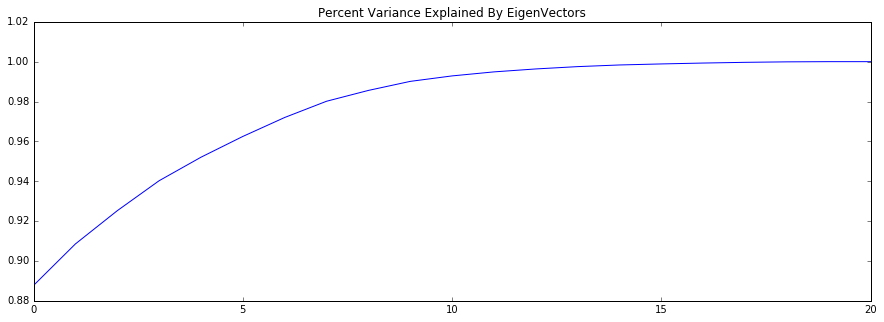

In [22]:
pca=PCA()
pca.fit(gb.as_matrix())

percentVar=pca.explained_variance_ratio_ 

top=[]
t=0
for i in range(len(percentVar)):
    t+=percentVar[i]
    top.append(t)
plt.figure(figsize=(15,5))
plt.plot(range(len(percentVar)),top)
plt.title('Percent Variance Explained By EigenVectors');


In [23]:
percentVar[0]

0.88773061017060839

As you can see from the graph above, the first eigenvector accounts for roughly 88% of the total variance.  Lets see what that vector looks like

In [24]:
gb.as_matrix().shape

(21, 53)

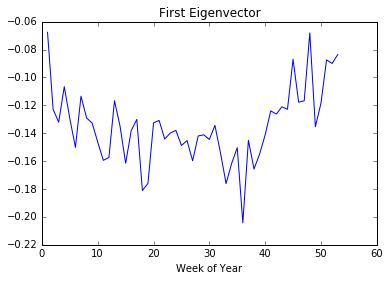

In [25]:
pca = PCA(n_components=1)
pca.fit(gb.as_matrix())
eigenvector=pca.components_ 

plt.plot(range(1,eigenvector.shape[1]+1),eigenvector[0])
plt.xlabel('Week of Year')
plt.title('First Eigenvector');

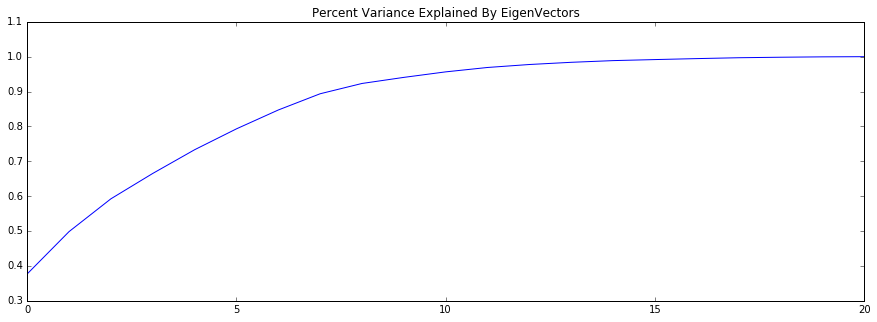

In [26]:
gb2=np.transpose(gb.as_matrix())
pca=PCA()
pca.fit(gb2)

percentVar=pca.explained_variance_ratio_ 

top=[]
t=0
for i in range(len(percentVar)):
    t+=percentVar[i]
    top.append(t)
plt.figure(figsize=(15,5))
plt.plot(range(len(percentVar)),top)
plt.title('Percent Variance Explained By EigenVectors');

Unfortunately, this interpretation of this eigenvector isn't jumping out at me.  So we will just continue with the features we selected using random forrest regressor.

Let's try to build that model now.  This time we will not use the UPC code of a product in the model but instead the "important features" of that product

Single Model Score:  0.782443130574
Cross Valid Scores:  [ 0.78298248  0.45690035  0.25947972  0.15299824  0.24250441  0.42074515
  0.67636684  0.64226656  0.78238342  0.64601477]


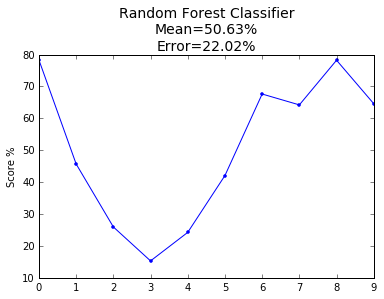

In [27]:
C=pd.merge(StoreStat,Product,how='inner',left_on='upc',right_on='UPC')
COMBINE=pd.get_dummies(C[['PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay',
          'FLAVOR/SCENT','L3','VOL_EQ','TYPE OF YOGURT','FAT CONTENT','STYLE']])
X=COMBINE.as_matrix()

y=C['More_1_std'].as_matrix()


#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Single Model Score: ", RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print "Cross Valid Scores: ", scores


plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

Looks like adding product attributes doesn't improve my model either.  In fact it makes it unstable. Lets try one more thing; stores (aka IRI_KEY)

# Stores

In other notebooks, my team looked at how the stores themselves affect yogurt sales.  For the first step let's see if knowing which store is running the promotion will improve our predictions

Single Model Score:  0.785182215987
Cross Valid Scores:  [ 0.78099857  0.78306878  0.7827381   0.7526455   0.60350529  0.74801587
  0.78141534  0.77191048  0.78194245  0.67842575]


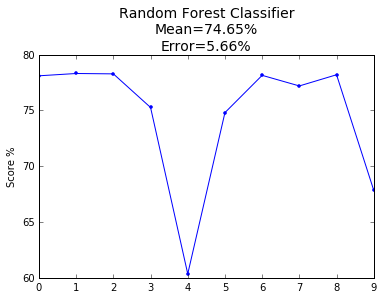

In [28]:
StoreStat['iriKey']=StoreStat.apply(lambda x:'%s' % (x['IRI_KEY']),axis=1)
C=pd.merge(StoreStat,Product,how='inner',left_on='upc',right_on='UPC')
COMBINE=pd.get_dummies(C[['iriKey','PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']])
X=COMBINE.as_matrix()

y=C['More_1_std'].as_matrix()


#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Single Model Score: ", RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print "Cross Valid Scores: ", scores


plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

My team member (in a different notebook) discovered during data exploration that some states appear to have higher mean weekly yogurt sales.  I will now try to incorporate state into the model.

In [29]:
STORE=pd.read_hdf('yogurt.h5','delivery_stores') # pull in table that gives information about stores
StoreStates=pd.read_csv('Market_Areas_States.csv') # file that compares Market Name with state
ST=pd.merge(STORE,StoreStates,how='inner',left_on='Market_Name',right_on='Market_Area') # merge tables, now I know the state of each IRI_KEY
AddState=pd.merge(StoreStat,ST[['IRI_KEY','State']],how='inner',on='IRI_KEY') # Add the state column to our other data

Single Model Score:  0.786282709824
Cross Valid Scores:  [ 0.78504185  0.73532177  0.78215413  0.78614688  0.73508672  0.78109489
  0.78505035  0.78531898  0.78479023  0.78433539]


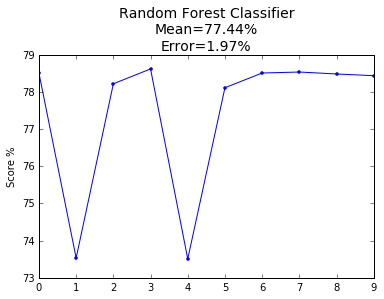

In [30]:
COMBINE=pd.get_dummies(AddState[['State','PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']])
X=COMBINE.as_matrix()

y=AddState['More_1_std'].as_matrix()


#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
print "Single Model Score: ", RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print "Cross Valid Scores: ", scores


plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

Knowing the store or the state doesn't improve the model.

# Tune Promotion Prediction Model

In [31]:
# Split the training dataset into train and validate
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(
    X_train, y_train, test_size=0.5, random_state=0)

tuned_parameters = {'n_estimators': [10,15,20], 'max_depth': [5,10,15,30]}

model=RandomForestClassifier()
search=GridSearchCV(estimator=model, param_grid=tuned_parameters)
search.fit(X_valid,y_valid)
print "Best Score: ",search.best_score_
# print (search.best_estimator_)
for run in range(len(search.grid_scores_)):
    print search.grid_scores_[run]


Best Score:  0.786314124351
mean: 0.78526, std: 0.00047, params: {'n_estimators': 10, 'max_depth': 5}
mean: 0.78560, std: 0.00045, params: {'n_estimators': 15, 'max_depth': 5}
mean: 0.78498, std: 0.00018, params: {'n_estimators': 20, 'max_depth': 5}
mean: 0.78620, std: 0.00011, params: {'n_estimators': 10, 'max_depth': 10}
mean: 0.78621, std: 0.00011, params: {'n_estimators': 15, 'max_depth': 10}
mean: 0.78622, std: 0.00011, params: {'n_estimators': 20, 'max_depth': 10}
mean: 0.78631, std: 0.00015, params: {'n_estimators': 10, 'max_depth': 15}
mean: 0.78627, std: 0.00012, params: {'n_estimators': 15, 'max_depth': 15}
mean: 0.78630, std: 0.00014, params: {'n_estimators': 20, 'max_depth': 15}
mean: 0.78629, std: 0.00011, params: {'n_estimators': 10, 'max_depth': 30}
mean: 0.78629, std: 0.00014, params: {'n_estimators': 15, 'max_depth': 30}
mean: 0.78628, std: 0.00013, params: {'n_estimators': 20, 'max_depth': 30}


Now lets run the model again, with the tuned parameters (even though they didn't really make a difference) and do cross validation

Model Score:  0.784762341045
Cross Valid Scores:  [ 0.7856503   0.78464252  0.79115926  0.78863974  0.78200498  0.7849944
  0.78398656  0.78409854  0.78395857  0.77995521]


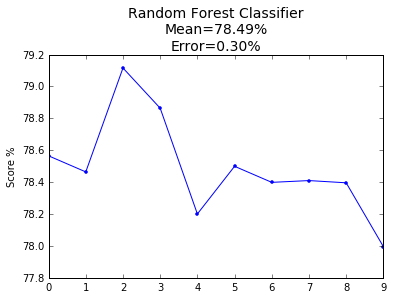

In [32]:
promo=['PR','ExistPromo','ExistDisplay','F_A','F_A+','F_B','F_NONE','NoDisplay','SmallDisplay','LargeDisplay']
X=StoreStat[promo].as_matrix()
y=StoreStat['More_1_std'].as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

RFC=RandomForestClassifier(n_estimators=20,max_depth=30)
RFC.fit(X_train,y_train)
print "Model Score: ",RFC.score(X_test,y_test)

CV = StratifiedKFold(y,n_folds=10)
scores = cross_val_score(RFC, X, y, cv=CV, n_jobs=-1)
print 'Cross Valid Scores: ', scores

plt.plot(scores*100,'.-')
plt.ylabel('Score %')
title = 'Random Forest Classifier\nMean=%.2f'%np.mean(scores*100)+'%'+'\nError=%.2f'%np.std(scores*100)+'%'
plt.title(title, fontsize=14);

# Build Sales Prediction Model

Let's see if it is possible to build a model that will predict the yogurt sales for a given week.  We will use the insights gained from this notebook but also the insights gained from my team members efforts on other aspects of the data.

Potential Features:
* Sales Promotions (Ads, Displays and price reductions)
* Product Attributes 
* Month of the Year
* State
* price
* outlet

We will attempt to build a regression model that predicts the units sold.  Since we have several features lets start with a LASSO regression. 

In [33]:
AddState=pd.merge(StoreData,ST[['IRI_KEY','State']],how='inner',on='IRI_KEY')
AddProduct=pd.merge(AddState,Product,how='inner',left_on='upc',right_on='UPC')
col=AddProduct.columns

In [34]:
features=col[[9,13,14,15,16,17,18,19,20,21,22,23,24,25,29,30,31,32,34,35,40,48,50,53]]
features

Index([u'PR', u'ExistPromo', u'ExistDisplay', u'drug', u'groc', u'price',
       u'F_A', u'F_A+', u'F_B', u'F_C', u'F_NONE', u'NoDisplay',
       u'SmallDisplay', u'LargeDisplay', u'WeekOfYear', u'Month', u'Year',
       u'State', u'FAT CONTENT', u'FLAVOR/SCENT', u'L3', u'STYLE',
       u'TYPE OF YOGURT', u'VOL_EQ'],
      dtype='object')

In [35]:
Data=pd.get_dummies(AddProduct[features])
Label=AddProduct['UNITS']

X=Data.as_matrix()
y=Label.as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Lasso regression
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)


0.327591379504


Pretty bad score, but lets still look at the features that were choosen.  

In [36]:
Coef=sorted(clf.coef_)
Coef[0:10]

[-11.993609799852297,
 -1.1794736056165176,
 -1.0943960709711134,
 -0.51175430284369383,
 -0.29509958209314391,
 -0.14874955127112457,
 -0.013928119671477793,
 0.0,
 0.0,
 0.0]

Looks like only 7 features were really used.  Below we discover what those features were

In [37]:
arr=np.array(clf.coef_)
idx=arr.argsort()[-7:][::-1]
Data.columns[idx]

Index([u'ExistPromo', u'State_OR', u'L3_PRIVATE LABEL', u'State_MD', u'PR',
       u'Year', u'groc'],
      dtype='object')

LASSO is a linear regression which probably not the way we want to go because we don't have any reason to believe there is a linear relationship.  But it did give us some insight into the features.

Now I want to try SVR.  But I'm not going to feed it all features like I did with LASSO because it doesn't run parallel so it would be very computationally expensive.  Just for fun, lets start with the features that LASSO identified.  We will expand from there

In [ ]:

# from sklearn.svm import SVR
# X=Data[['ExistPromo', 'State_OR', 'L3_PRIVATE LABEL', 'State_MD', 'PR','Year', 'groc']].as_matrix() #features identified by LASSO
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# clf = SVR(C=1.0, epsilon=0.2)
# clf.fit(X_train, y_train) 
# clf.score(X_test,y_test)


SVC still took way to long to run. Unfortunately, we don't have the resources set up at this point to run multiple iterations of SVR to optimize, tune and cross validate.

Let me see if I can get better results using Ridge Regression

In [38]:
X=Data.as_matrix()
y=Label.as_matrix()

#Split Training/Testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Ridge regression
clf = linear_model.Ridge()
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.438424413536


Ridge performs better than Lasso, still not great score.  Last attempt:  Let's see if tuning the parameters will help

In [39]:
# Split the training dataset into train and validate
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(
    X_train, y_train, test_size=0.5)

tuned_parameters = {'alpha': [1.0,0.5,0.1]}

model=linear_model.Ridge()
search=GridSearchCV(estimator=model, param_grid=tuned_parameters)
search.fit(X_valid,y_valid)
print "Best Score: ",search.best_score_
# print (search.best_estimator_)
for run in range(len(search.grid_scores_)):
    print search.grid_scores_[run]

Best Score:  0.425854546551
mean: 0.42561, std: 0.00678, params: {'alpha': 1.0}
mean: 0.42583, std: 0.00712, params: {'alpha': 0.5}
mean: 0.42585, std: 0.00746, params: {'alpha': 0.1}
